In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import itertools

from matplotlib import container

In [3]:
summary_df = pd.read_csv("aggregate_summary_all.csv", index_col=0)
molecules = summary_df["molecule"]
molecule_set = set(molecules)
group_key = "molecule"
g_list = list()

In [25]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


# Data cleaning and intial set up

In [15]:
def mean_confidence_interval(m,se, confidence=0.95):  
    se = np.array(se)
    n = 16
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [16]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [17]:
from pprint import pprint

def data_cleaning(molecule_set):
    """Make sure properties of all molecule in the provided molecule_set has been calculated."""
    for molecule in molecule_set:
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + "K , "
            + summary_df["pressure"].map(str)
            + "kPa"
        )
        sp_set = set(mol_df["statepoint"])
        goods = list()
        bads = list()
        for engine in mol_df["engine"].unique():
            found_sp = mol_df[mol_df["engine"] == engine].index.tolist()
            if len(found_sp) == len(set(mol_df["statepoint"])):
                goods.append((engine, found_sp))
            else:
                mol_df.drop(axis=0, labels=found_sp, inplace=True)
                bads.append((engine, found_sp))
        print(molecule)
        if goods:
            print(f"\tPassed: {[good[0] for good in goods]}")
        if bads:
            print(f"\tFailed: {[bad[0] for bad in bads]}")

data_cleaning(molecule_set)

benzeneUA
	Passed: ['hoomd', 'cassandra', 'gromacs', 'gomc', 'mcccs', 'lammps-VU']
ethanolAA
	Passed: ['gromacs', 'mcccs', 'lammps-VU', 'cassandra', 'gomc', 'hoomd']
waterSPCE
	Passed: ['gomc', 'lammps-VU', 'hoomd', 'cassandra', 'mcccs', 'gromacs']
pentaneUA-flexible_bonds
	Passed: ['gromacs', 'hoomd', 'lammps-VU']
pentaneUA-constrain_bonds
	Passed: ['gomc', 'gromacs', 'hoomd', 'mcccs', 'cassandra']
methaneUA
	Passed: ['lammps-VU', 'hoomd', 'gomc', 'cassandra', 'mcccs', 'gromacs']


# Style set up

In [18]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [19]:
all_engine_molecule = ("methaneUA", "ethanolAA", "waterSPCE",)
pentane_fixed = ("pentaneUA-constrain_bonds",)
pentane_flexible = ("pentaneUA-flexible_bonds",)
rigid_benzene = ("benzeneUA",) 

md_only = ["lammps-VU", "hoomd", "gromacs"]
mc_only = ["mcccs", "gomc", "cassandra"]

all_engine_orders = ("lammps-VU", "hoomd", "gromacs", 
                    "mcccs", "gomc", "cassandra")
pentane_fixed_orders = ("hoomd", "gromacs", 
                       "mcccs", "gomc", "cassandra")
pentane_flexible_orders = ("lammps-VU", "hoomd", "gromacs")
rigid_benzene_orders = ("lammps-VU", "hoomd", 
                    "mcccs", "gomc", "cassandra")

# Colors
symbols = {}
symbols["cassandra"] = "o"
symbols[ "mcccs"] = "^"
symbols["gomc"] = "s"
symbols["gromacs"] = "x" 
symbols[ "hoomd"] = "v" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#045275" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#089099" #(194/256, 135/256, 32/256)
colors["gomc"] = "#7CCBA2" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#F0746E" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#DC3977" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#7C1D6F" #(188/256, 146/256, 110/256)

# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}

pretty_names = {
    "cassandra": "Cassandra (MC)",
    "mcccs": "MCCCS-MN (MC)", 
    "gomc": "GOMC (MC)",
    "gromacs": "GROMACS (MD)", 
    "hoomd": "HOOMD-blue (MD)", 
    "lammps-VU": "LAMMPS (MD)",
}

fill_styles = {
    "cassandra": "none", 
    "mcccs": "none", 
    "gomc": "none", 
    "gromacs": "full", 
    "hoomd": "full",
    "lammps-VU": "full",
}

In [86]:
def create_stacked_density_deviation_plots(molecules, engines, figsize):
    for molecule in molecules:
        #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True, sharey=False)
        
        try:
            mol_group = summary_df.groupby(group_key)
            mol_df = mol_group.get_group(molecule)
        except KeyError:
            print(f"skipping: {molecule}, no data available.")
            continue
        mol_df["statepoint"] = (
            summary_df["temperature"].map(str)
            + " K, "
            + round(summary_df["pressure"] / 101.325, 2).map(str)
            + " atm"
            )
        statepoints = sorted(set(mol_df["statepoint"]))
        statepoints_overall_means = list()

        xticks = list()
        sps_positions = list()
        for n_statepoint, statepoint in enumerate(statepoints):
            densities = list()
            stds = list()
            sems = list()
            for engine in engines:
                shortlisted = mol_df[
                    (mol_df["engine"]==engine)
                  & (mol_df["statepoint"]==statepoint)]
                # densities.append(shortlisted["density-avg"])
                # stds.append(shortlisted["density-std"])
                # sems.append(shortlisted["density-sem"])
                densities.append(shortlisted["density-avg"]*1000)
                stds.append(shortlisted["density-std"]*1000)
                sems.append(shortlisted["density-sem"]*1000)
            overall_mean = np.mean(densities)
            statepoints_overall_means.append(overall_mean)

            confidence_interval = mean_confidence_interval(densities, np.array(sems), confidence=0.95)
            percentage_delta_density = (densities-overall_mean) * 100 / overall_mean
            percentage_sem_density = 100 * np.array(sems) / overall_mean
            percentage_ci_density = 100 * np.array(confidence_interval) / overall_mean

            ind = list()
            sp_position = list()
            for i, engine in enumerate(engines): 
                ind.append(i)
                sp_position.append(1*n_statepoint + 0.1*i)
                ax[0].errorbar(
                     1*n_statepoint + 0.1*i, 
                     densities[i],  
                     marker=symbols[engine],
                     yerr=sems[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
                ax[1].errorbar(
                     1*n_statepoint + 0.1*i, 
                     percentage_delta_density[i],  
                     marker=symbols[engine],
                     yerr=percentage_ci_density[i],
                     color=colors[engine], 
                     fillstyle=fill_styles[engine],
                     ls='',
                     label=engine,
                    )
            sps_positions.append(np.mean(sp_position))
            xticks.append(statepoint+r'$\rho_{\mathrm{ave}}$'+r'$ = {:.3f}$'.format(overall_mean))
        
        if molecule == "waterSPCE":
            #ax[0].set_ylim(0.984, 1.01)
            ax[0].set_ylim(984, 1010)
        ax[1].set_xlabel("State point")
        ax[1].set_ylabel(r"$\frac{100\times\Delta\rho}{\rho}$")
        #ax[0].set_ylabel(r"$\rho$  $[\frac{g}{cm^3}]$")
        ax[0].set_ylabel(r"$\rho$,  $\frac{kg}{m^3}$")

        ax[0].tick_params(axis='y')
        #plt.title(f"{molecule}")
        props = dict(boxstyle='round', facecolor='none',alpha=1, ec = 'grey')
        #string+='{:.5f}'.format(overall_mean)

        ax[0].set_xticks([pos for pos in sps_positions])    
        ax[0].set_xticklabels([
            f'{sp}\n' +r'$\rho_{\mathrm{ave}}$'+'$ = {:.3f}$'.format(sp_omean) 
            for sp_omean, sp in zip(statepoints_overall_means, statepoints)
            ]
        )

        # Handle ylim 
        low_dens, high_dens = ax[0].get_ylim()
        density_average = np.mean(statepoints_overall_means) 
        dens_bound = max(abs(density_average-high_dens), 
                         abs(density_average-low_dens))
        ax[0].set_ylim(density_average - dens_bound, 
                       density_average + dens_bound)
        
        low, high = ax[1].get_ylim()
        bound = max(abs(low), abs(high))
        #ax1.set_ylim(-bound*1.1, bound*1.1) 
        ax[1].set_ylim(-bound*1.1, bound*1.1)
        
        

        # get handles
        #wrap_labels(ax, 10)
        handles, labels = ax[1].get_legend_handles_labels()
        
        #Sorting handles and labels: 
        labels_handles = dict()
        for handle, label in zip(handles, labels):
            labels_handles[label] = handle
        sorted_handles = [labels_handles[engine] for engine in engines]
        sorted_labels = [pretty_names[engine] for engine in engines]
        plt.legend(flip(sorted_handles, 3), 
                   flip(sorted_labels, 3),
                   bbox_to_anchor=(0.6, 1.09),
                   bbox_transform=fig.transFigure,
                   labelspacing=2,
                   facecolor='white', 
                   loc='upper center',
                   prop={'size': 12},
                   ncol=3)
        
        #plt.subplots_adjust(bottom=0)
        plt.tight_layout()
        ax[0].grid(b=None) #alpha = 0., axis='x')
        ax[1].grid(b=None) #alpha = 0., axis='x')
        
        
        ax[0].tick_params(which='both', width=1)
        ax[0].tick_params(which="major", length=8, axis="y", bottom=False)
        ax[0].tick_params(which="minor", length=4, axis="y", bottom=False)
        ax[0].minorticks_on()
        
        ax[1].tick_params(which='both', width=1)
        ax[1].tick_params(which="major", length=8, axis="y", bottom=False)
        ax[1].tick_params(which="minor", length=4, axis="y", bottom=False)
        ax[1].minorticks_on()
        
        plt.savefig(f"figures/{molecule}_stacked_deviation_density.pdf", 
                    dpi=500, 
                    bbox_inches='tight')
        plt.show()
        plt.close()

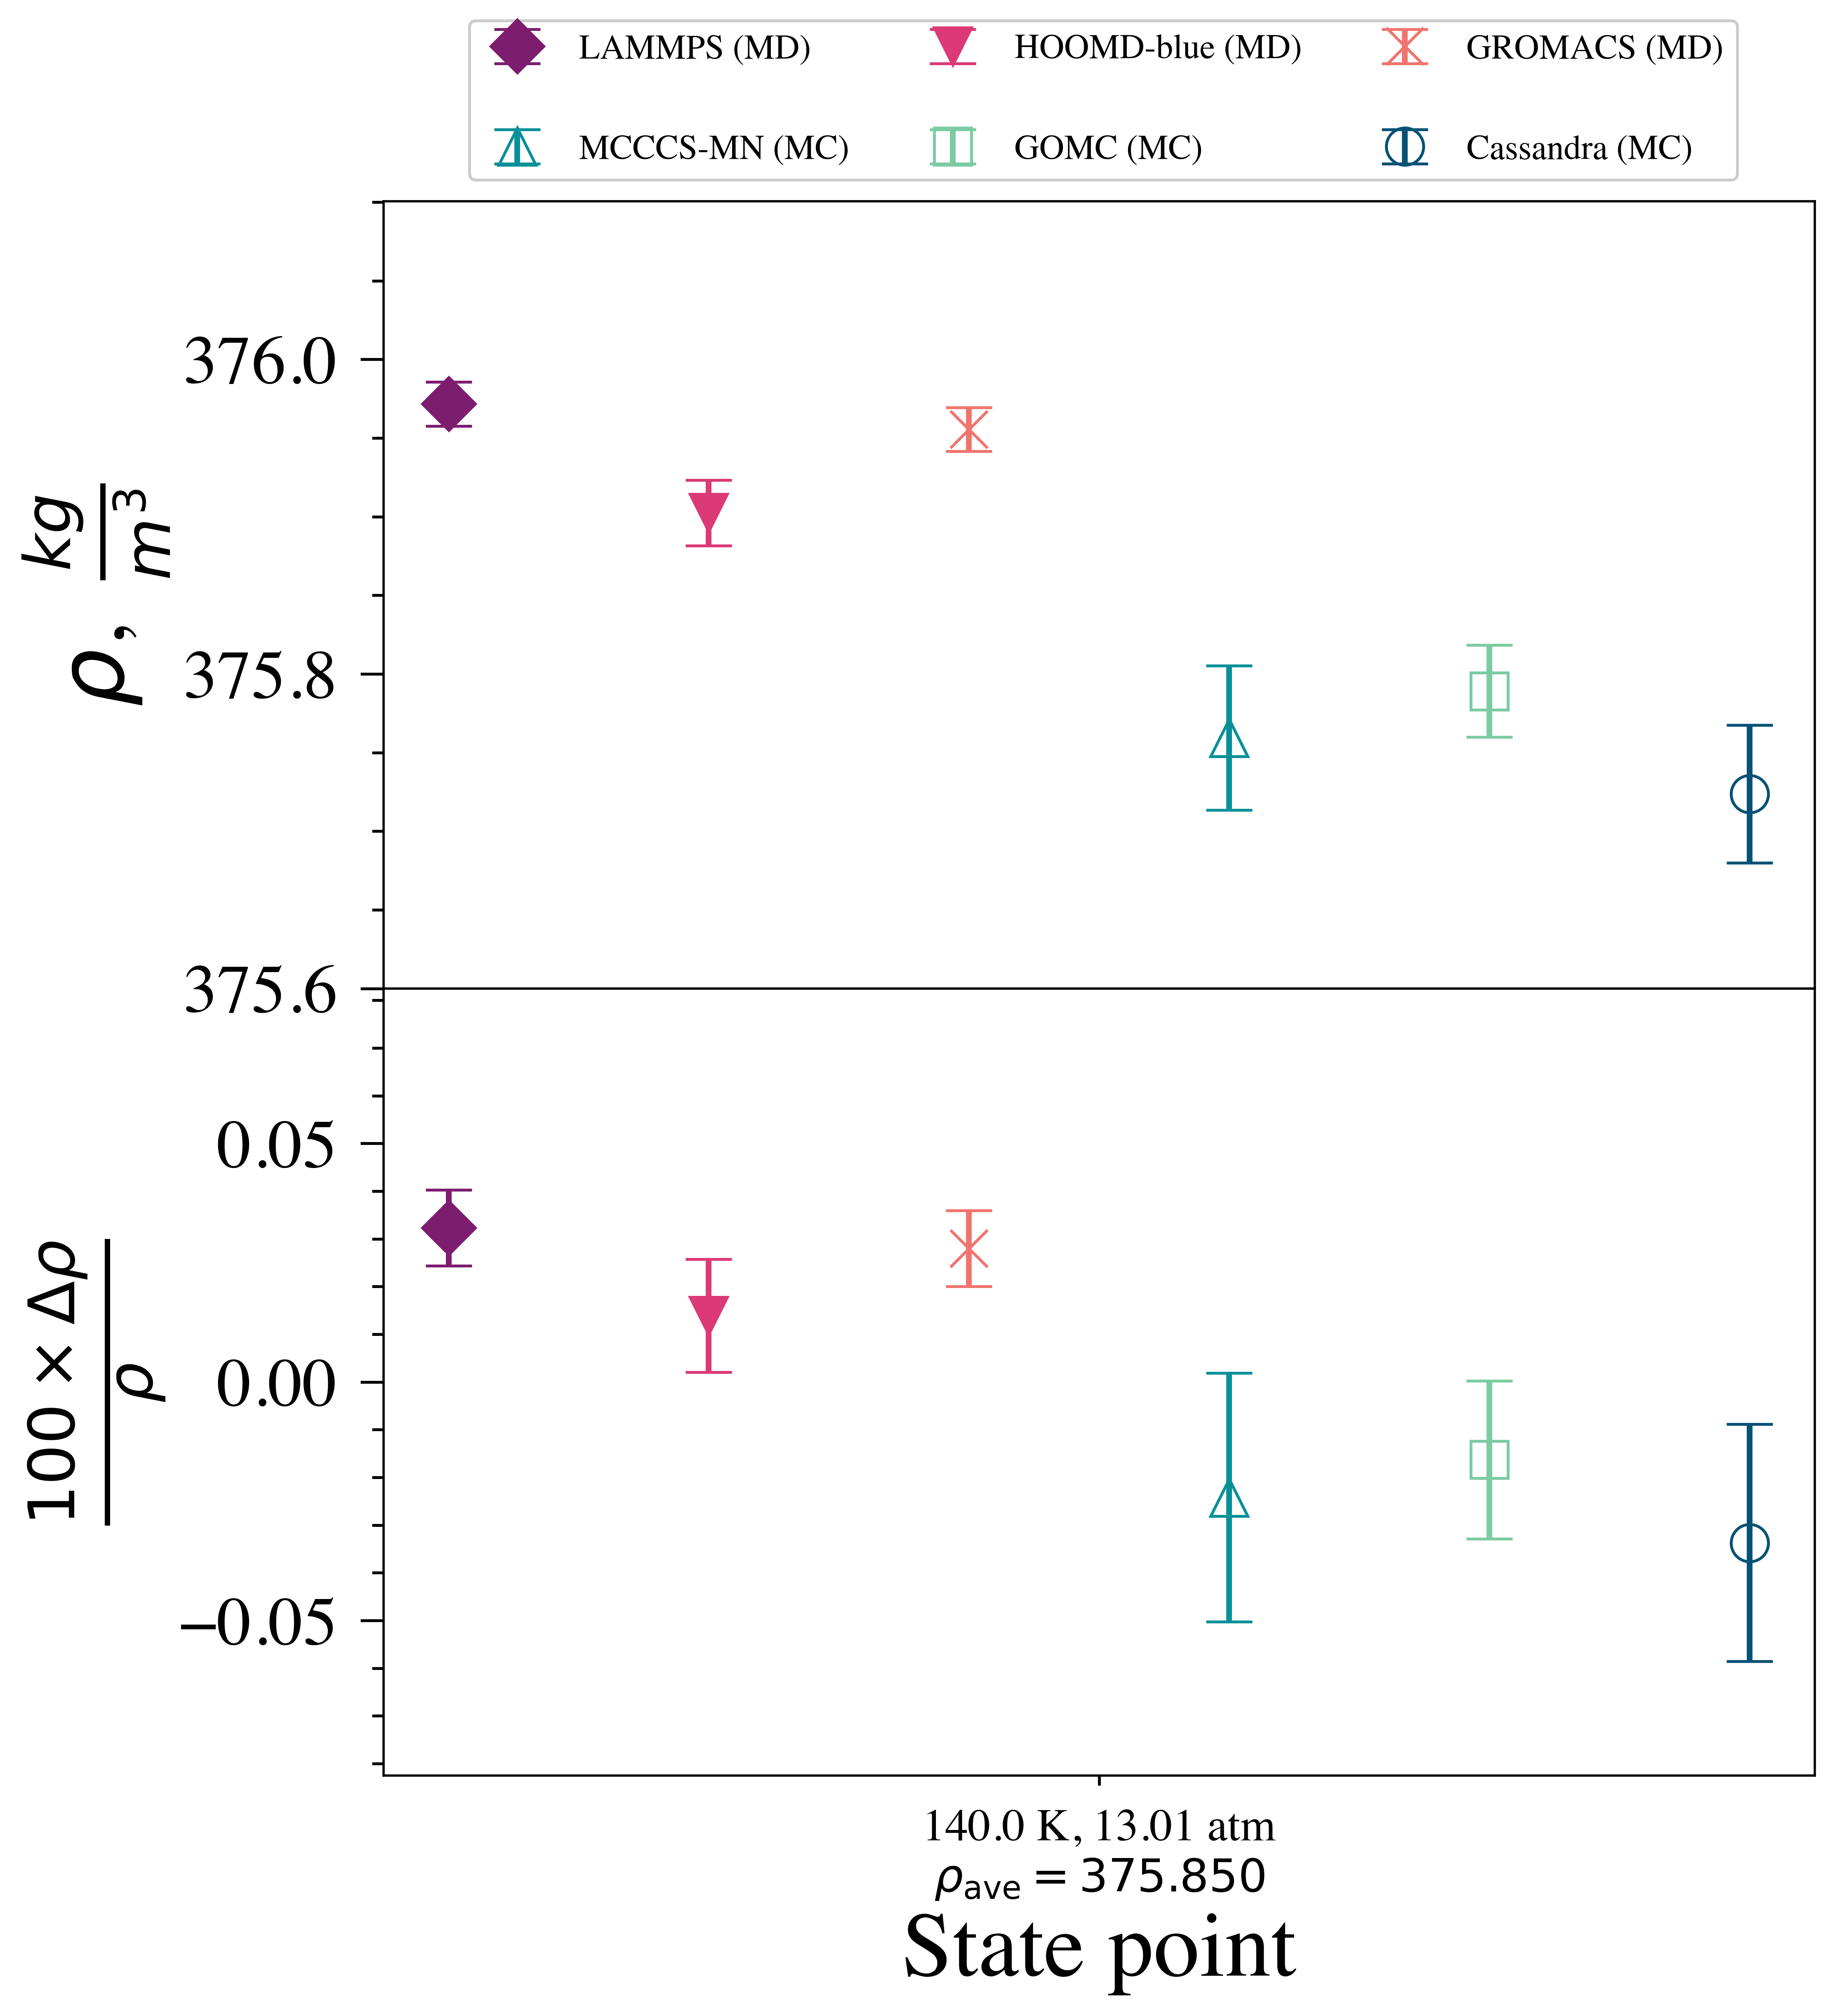

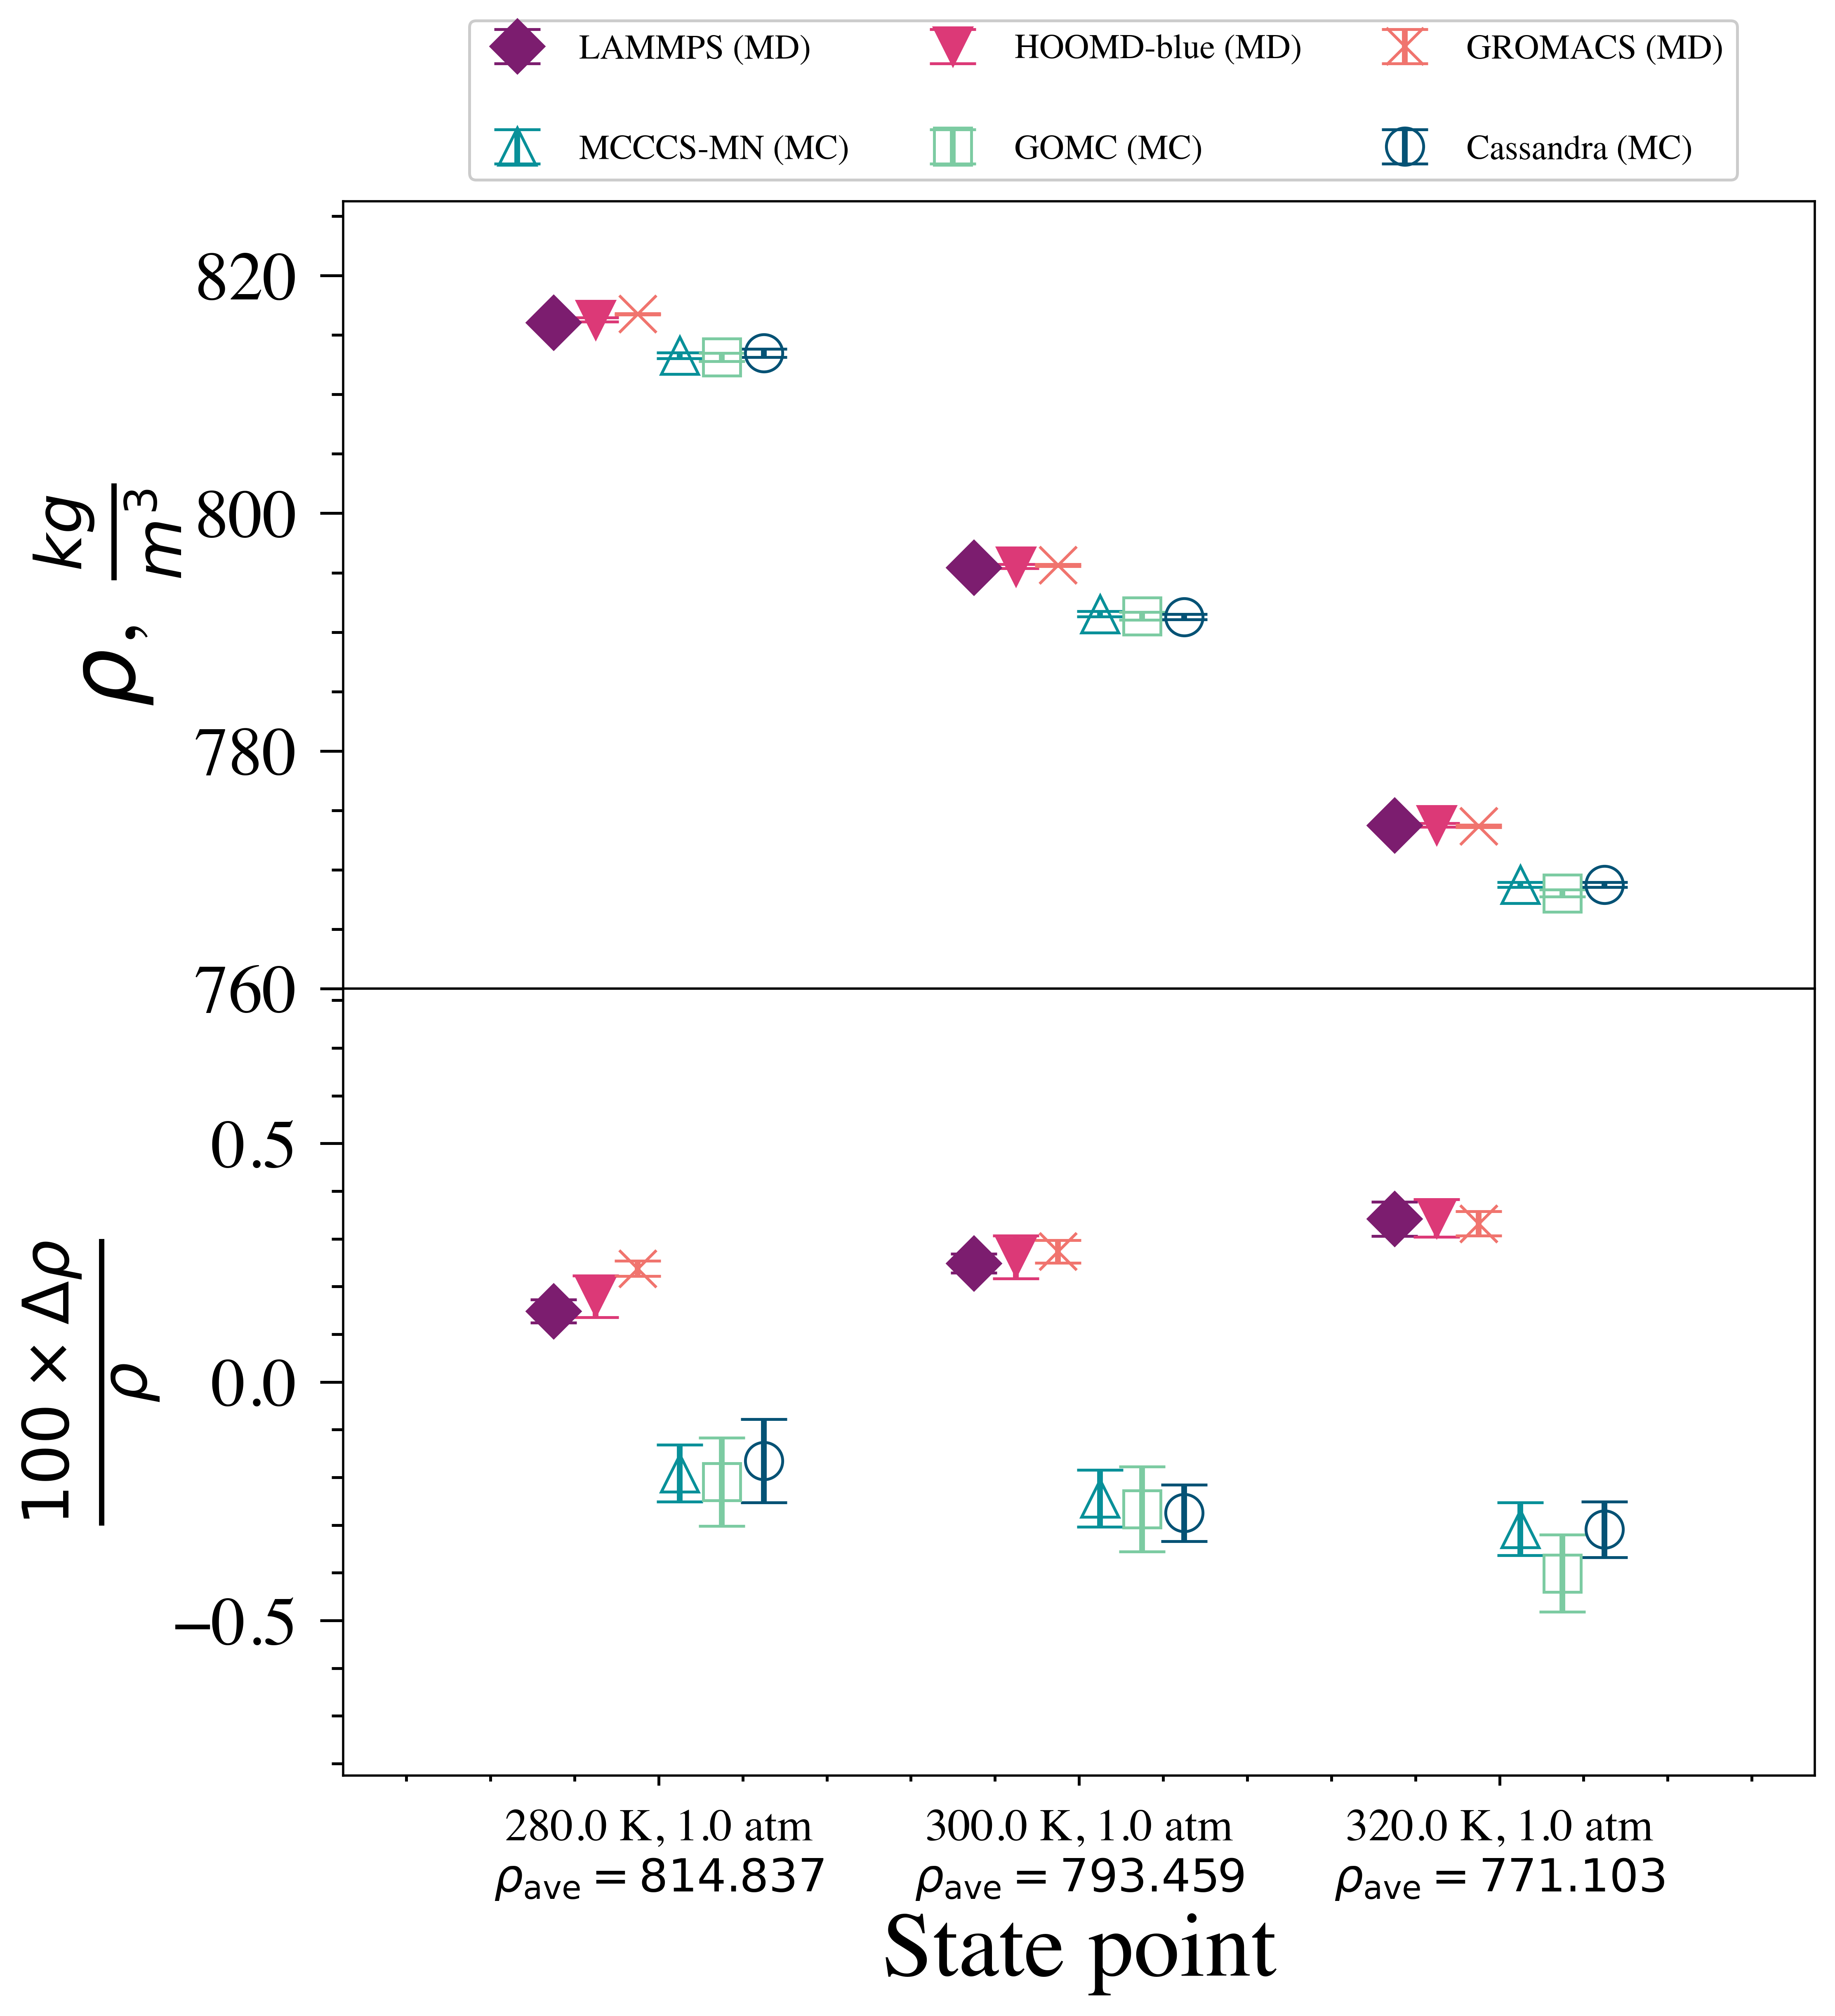

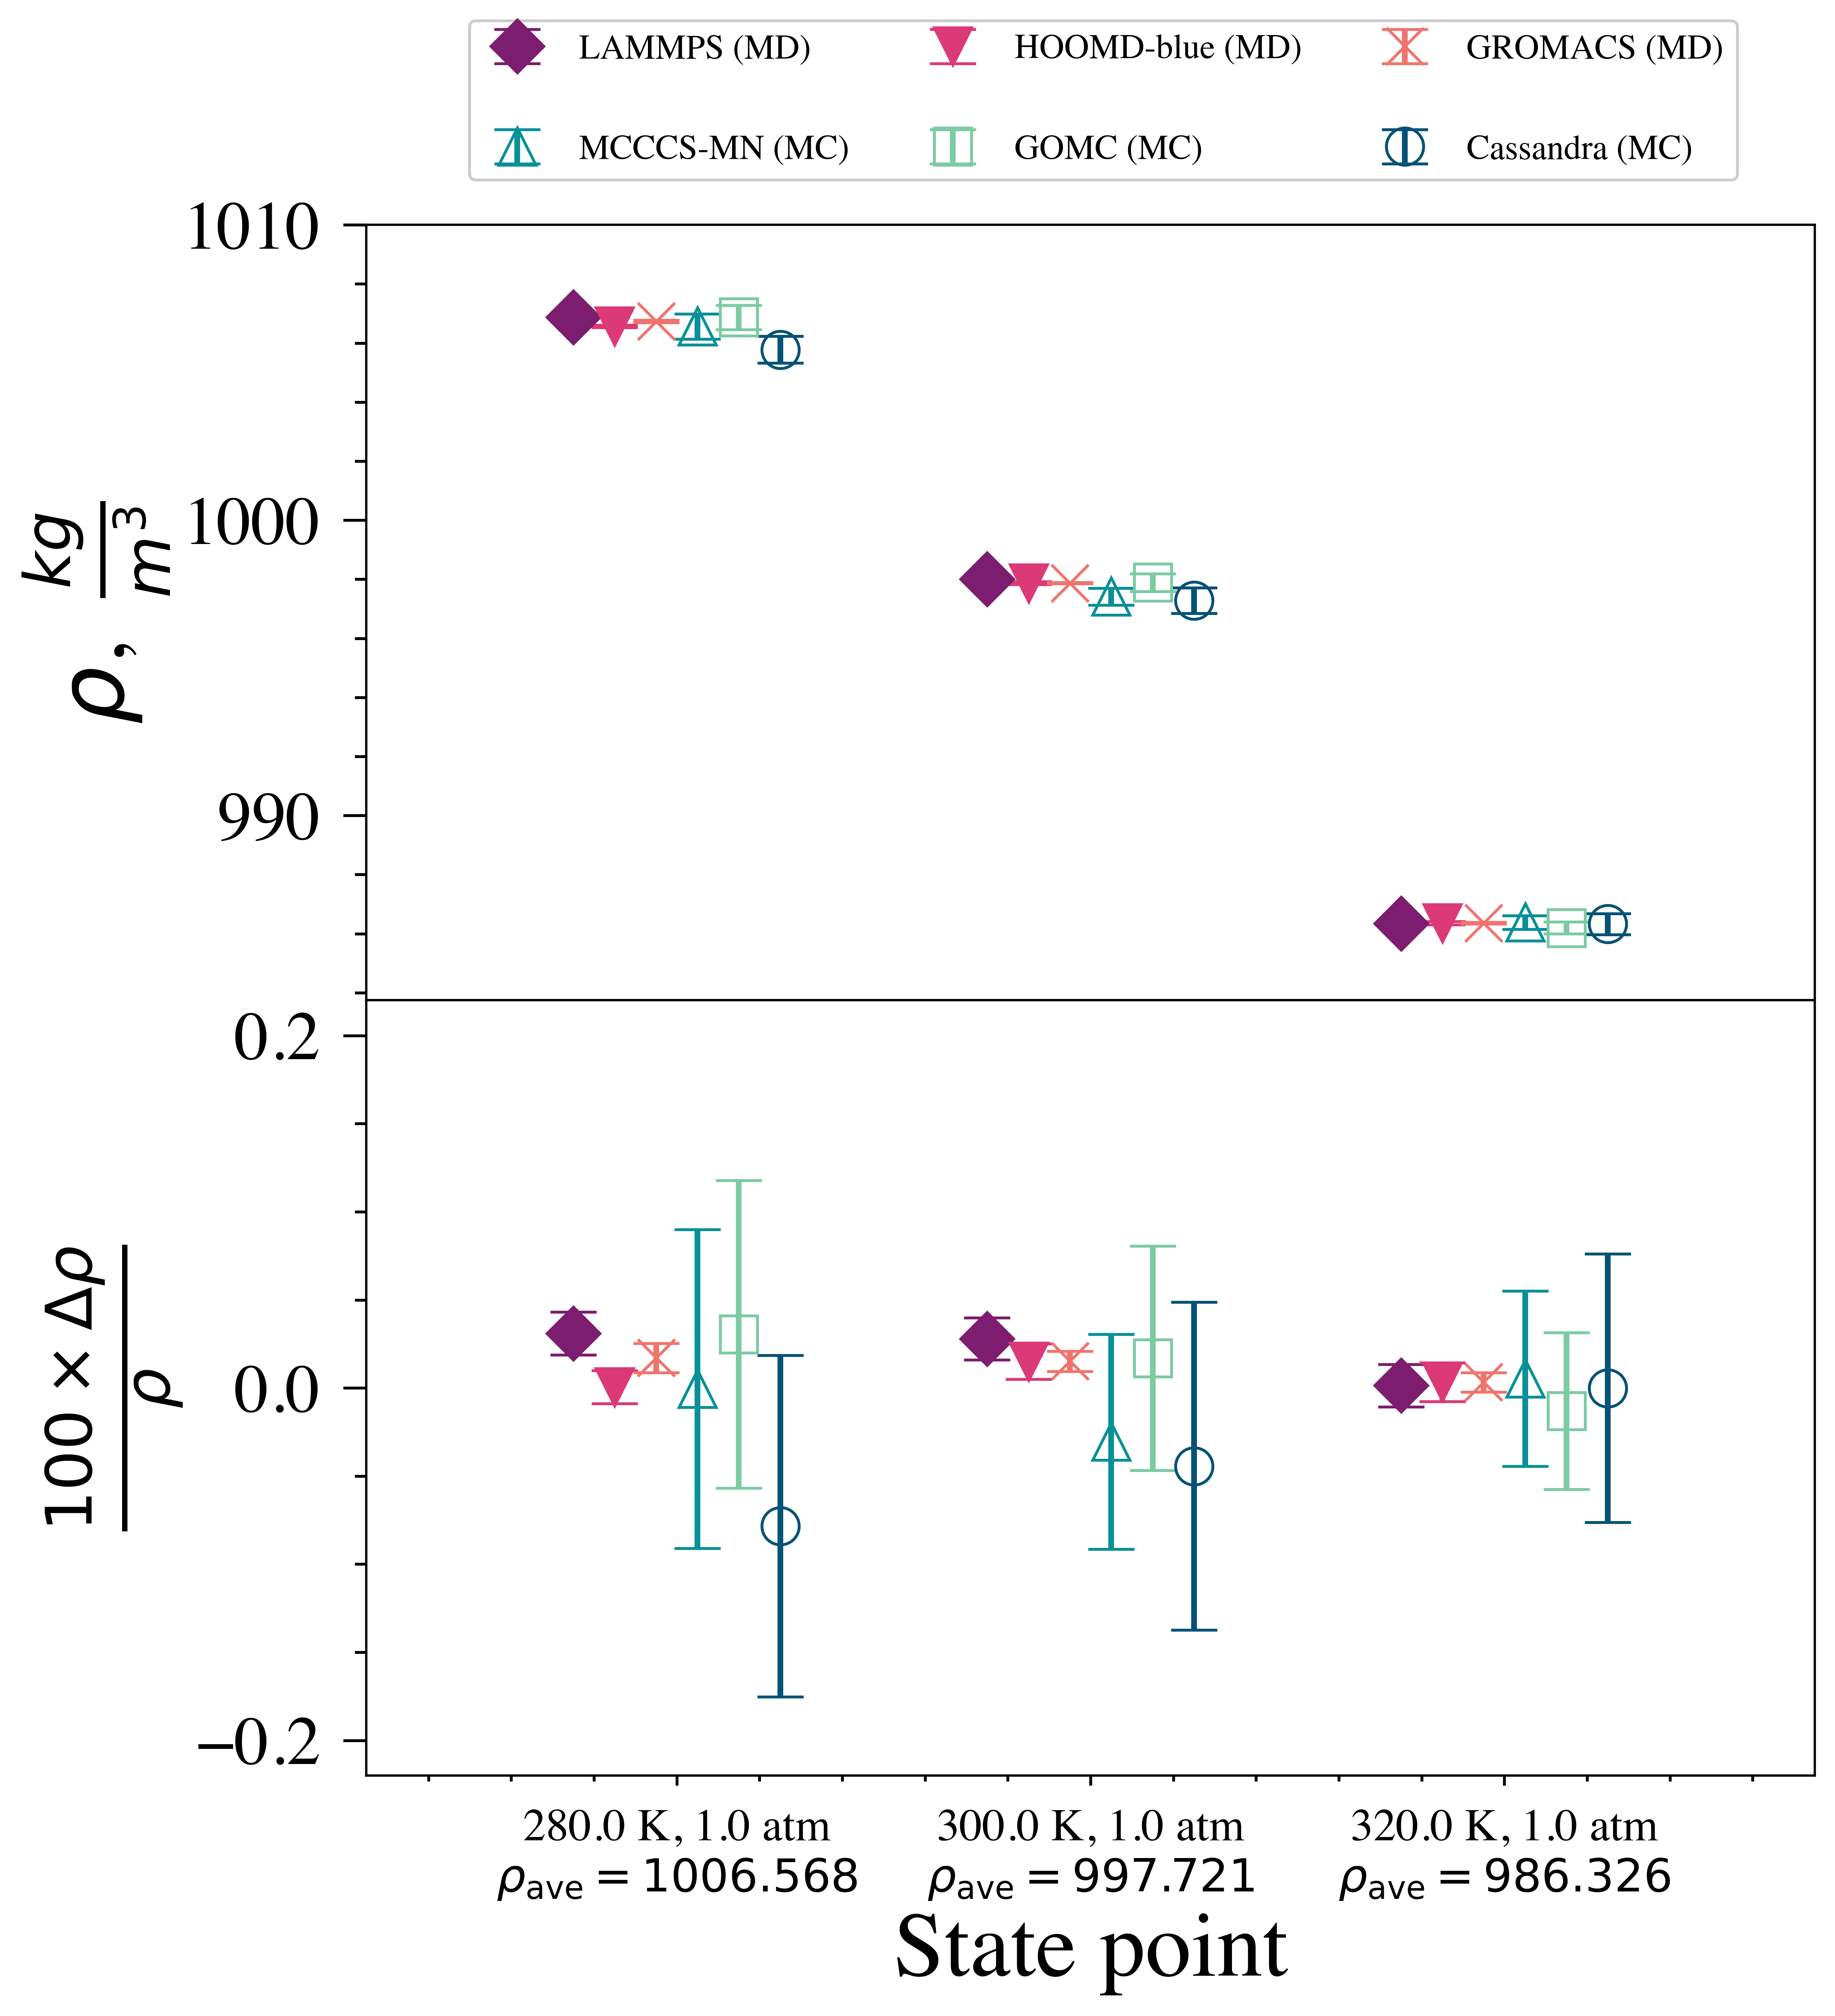

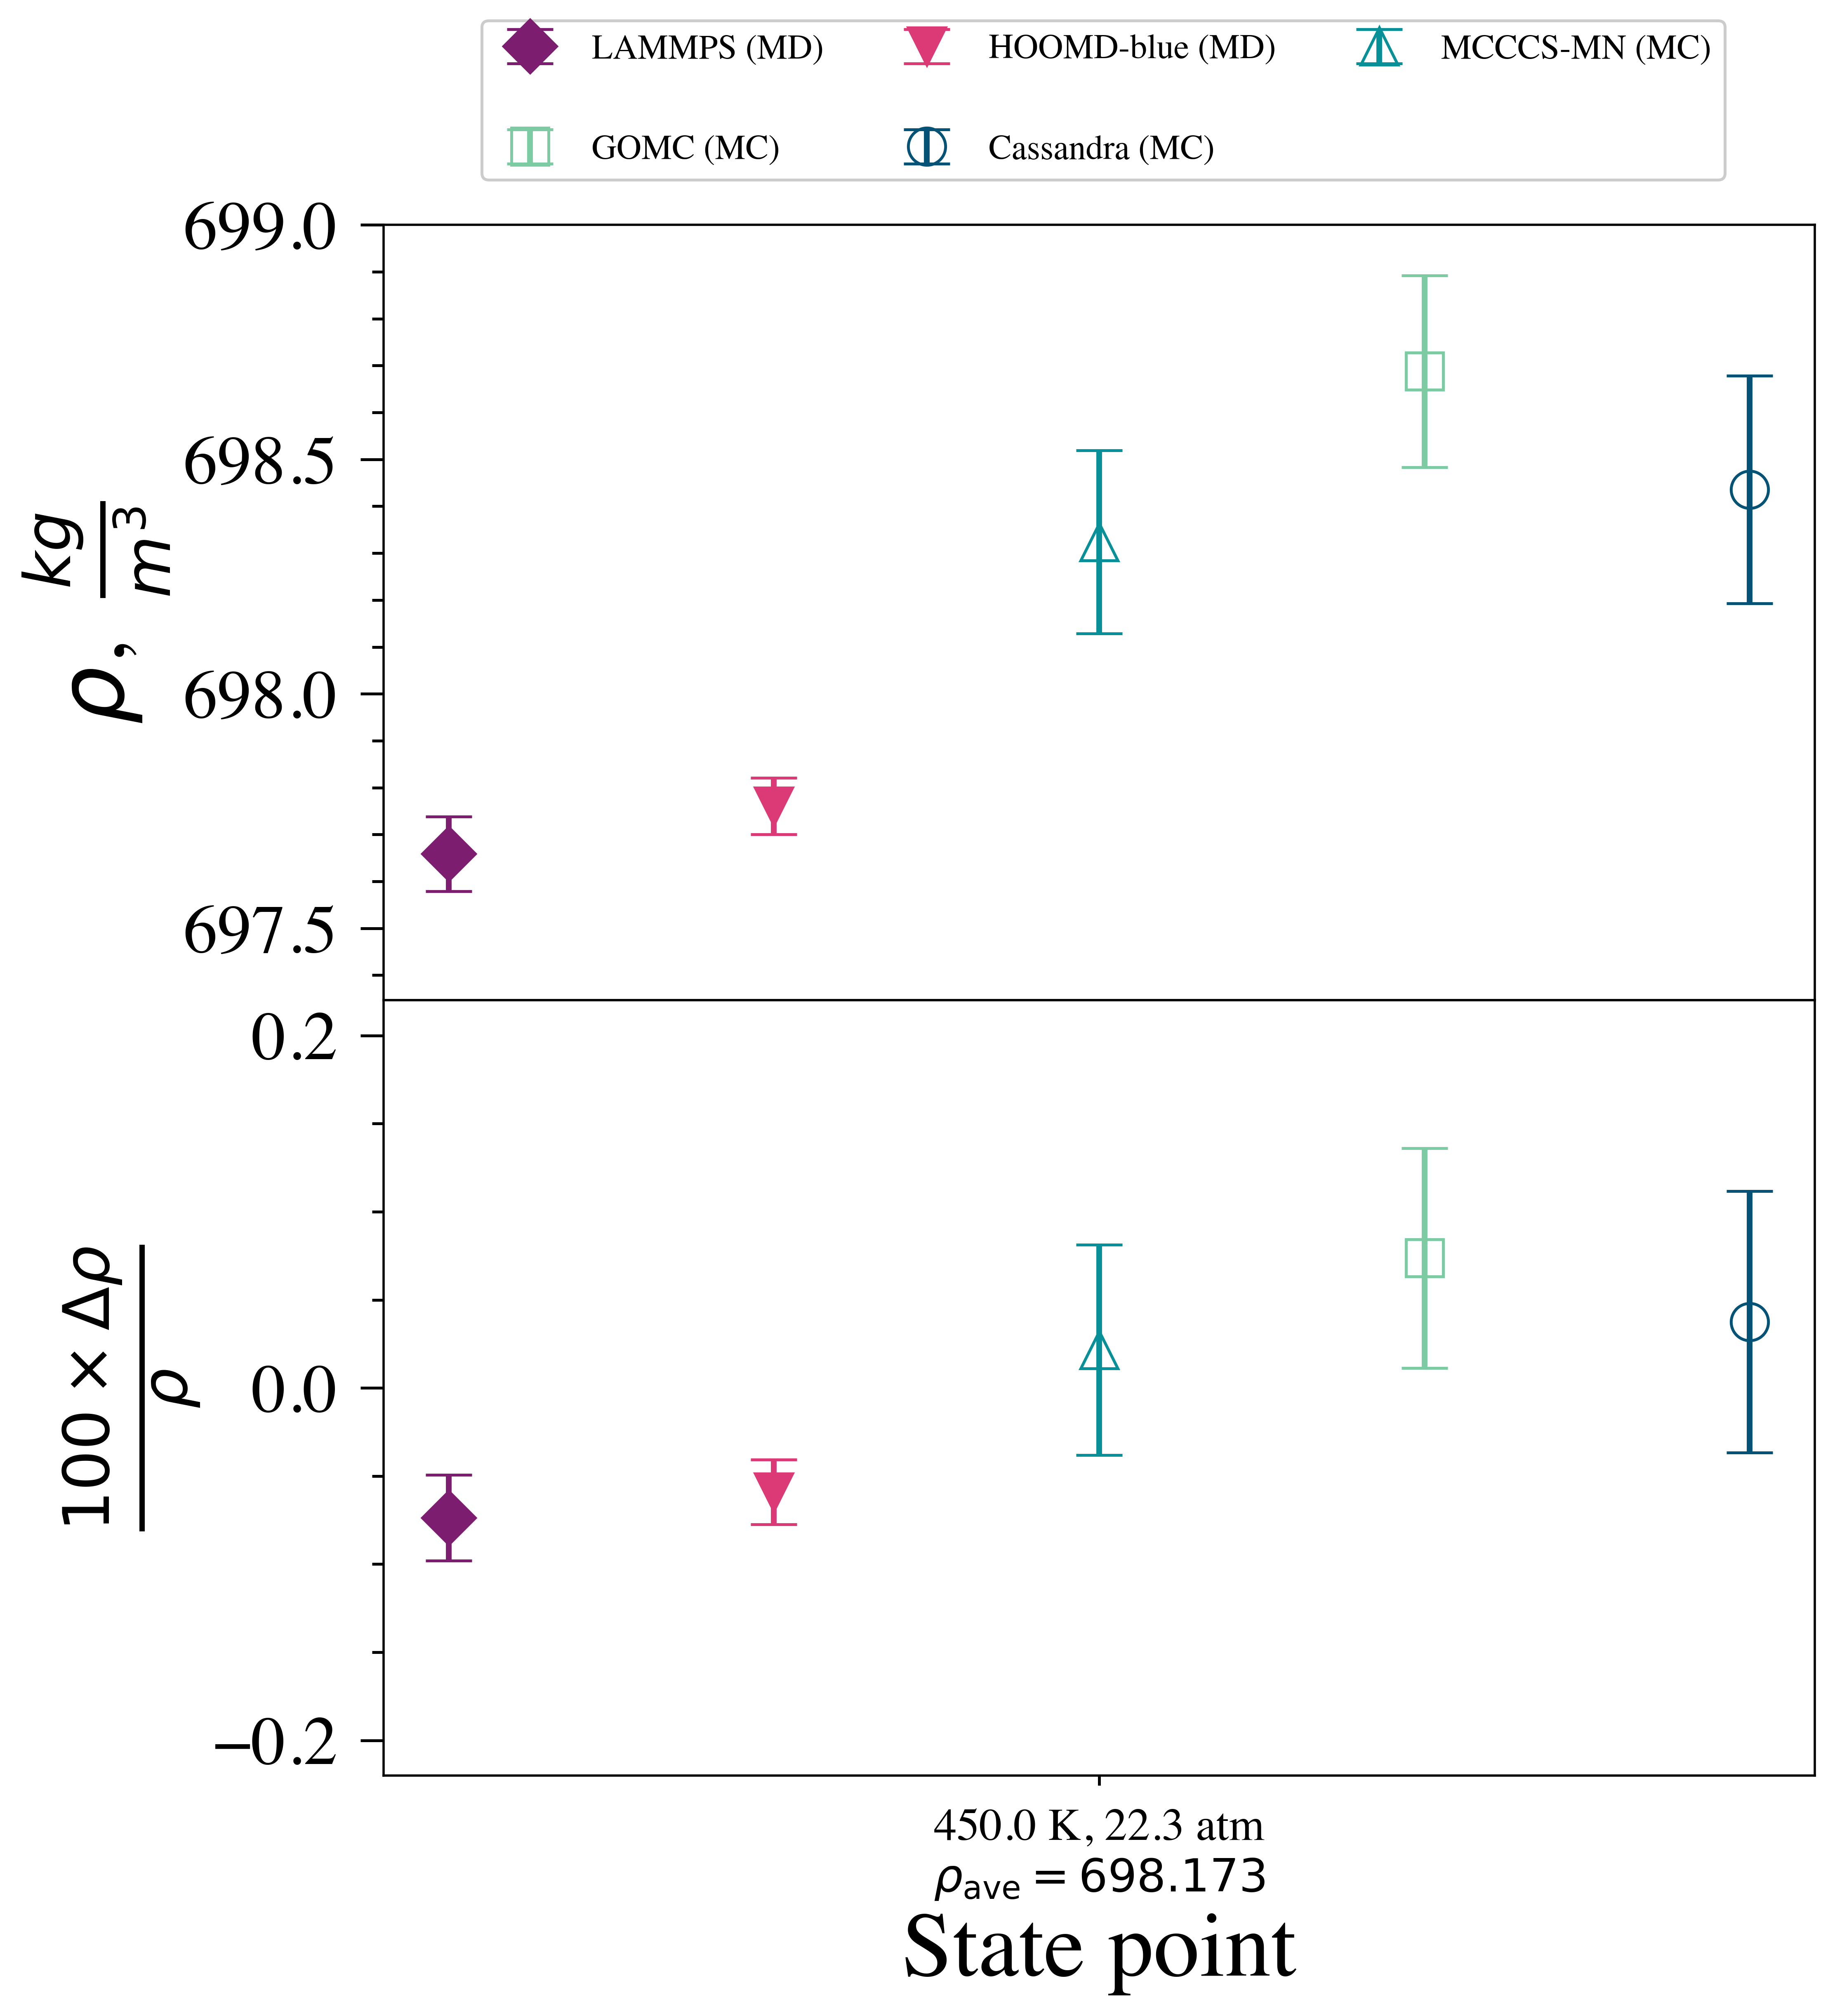

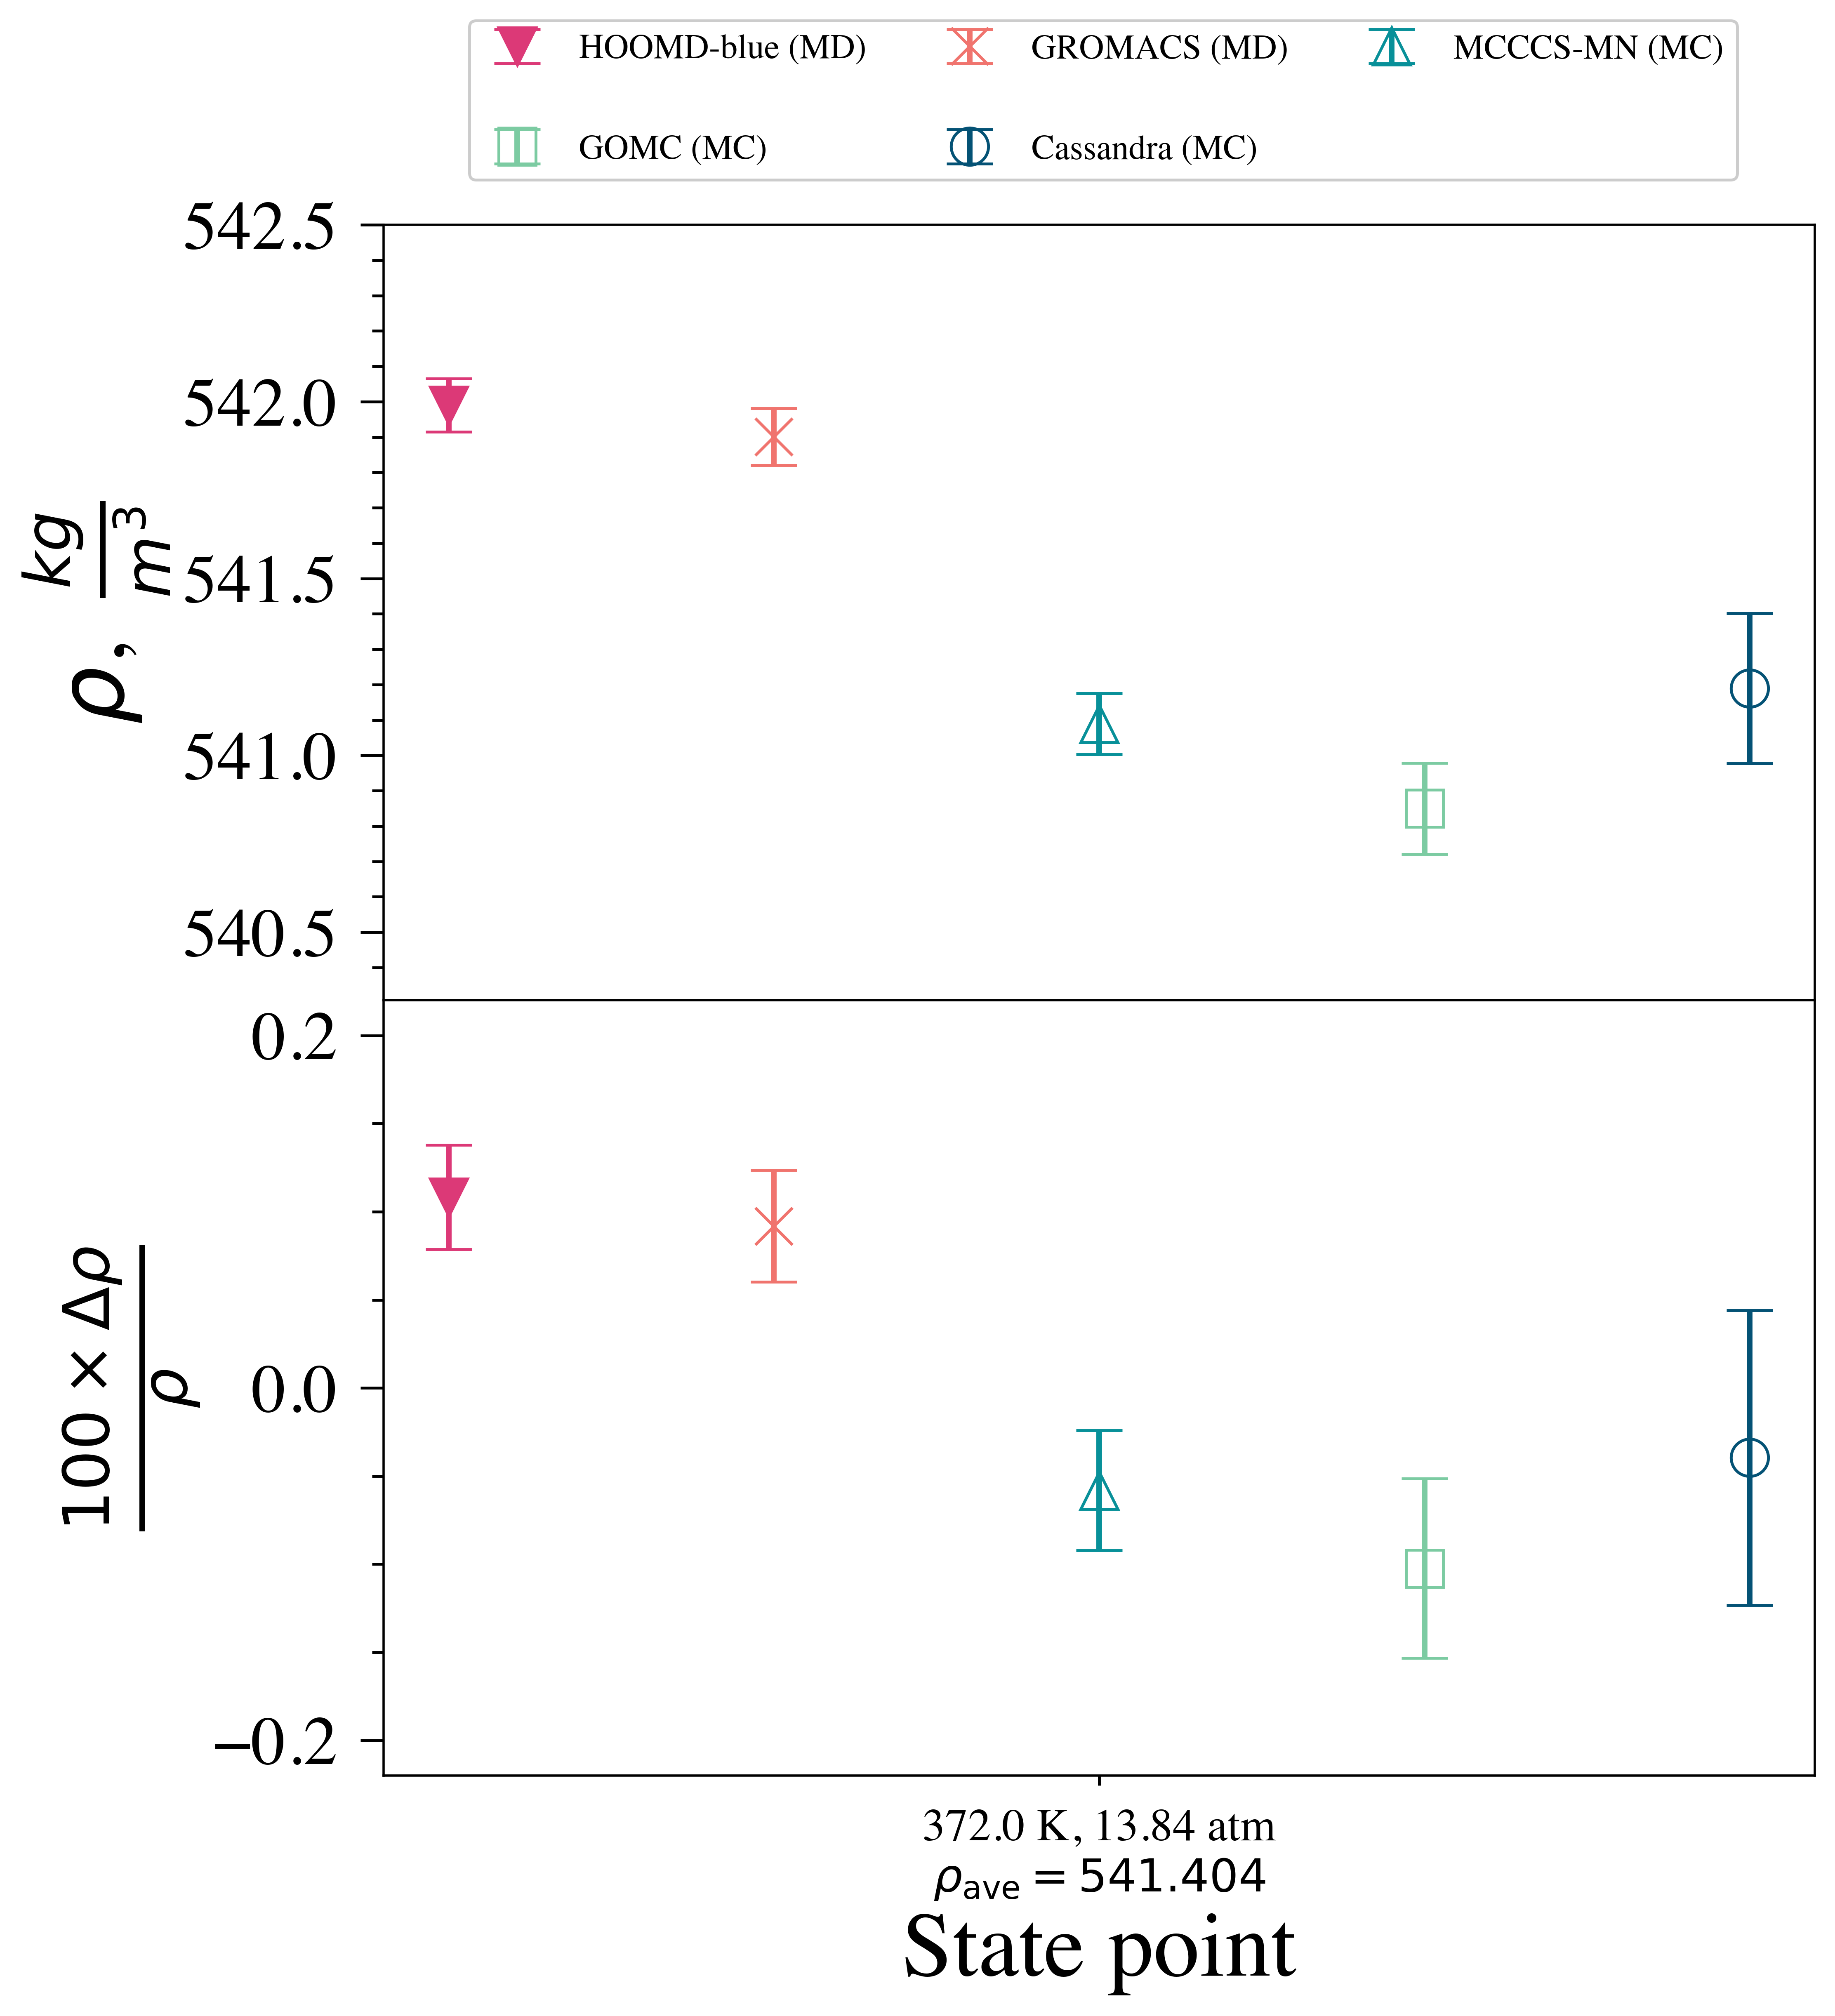

In [87]:
modfigsize = [9, 9]
create_stacked_density_deviation_plots(all_engine_molecule, all_engine_orders, modfigsize)
create_stacked_density_deviation_plots(rigid_benzene, rigid_benzene_orders, modfigsize)
create_stacked_density_deviation_plots(pentane_fixed, pentane_fixed_orders, modfigsize)
#create_stacked_density_deviation_plots(pentane_flexible, pentane_flexible_orders, modfigsize)